# **COMP 2211 Exploring Artificial Intelligence** #
## Lab 6 Multilayer Perceptron ##
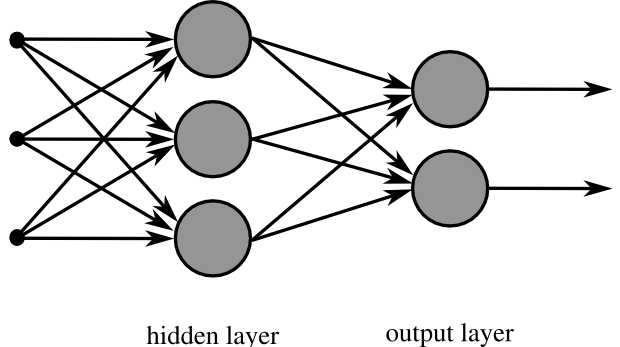

This lab tackles the **Sentiment Analysis** task and uses the **Twitter US Airline Sentiment** data. We believe you are quite familiar with the task and the dataset after lab2 and PA1, where you implemented the Naive Bayes classifier and K-Nearest Neighbors classifier for the sentiment analysis task. In this lab, you will build an MLP model for the task. Before building the model, you will also learn how to process the raw CSV data.

## **Submission to ZINC**
After completing the missing functions in this notebook, successfully running the code, and achieving the task score requirement, please COPY your functions to the template lab6_task.py (do not change the file name) given in the lab6 webpage, **DIRECTLY COMPRESS the 3 items** (lab6_task.py, X_test.npy, weights.hdf5) to a zip file instead of compressing a folder containing the 3 items. Submit ONLY the zip file to ZINC.

## Before We Begin

Run the code in the following two code cells to "mount" the Google Drive directory.

### Mount Google Drive
Download and save a copy of the lab6 files, including the Notebook and an excel file (i.e. *Tweets.csv*), ensuring all the files are in the same location.

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


Modify the pathway of the *%cd* shell command according to the location in your Google Drive where you have saved the Notebook and datasets. Double-check the output of the *%ls* shell command to ensure that you are in the correct working directory. It should display the filenames of *lab6_task.ipynb* and *Tweets.csv*.

In [3]:
%cd "/content/drive/My Drive/Colab Notebooks/COMP2211 LAB6_/"
%ls

/content/drive/My Drive/Colab Notebooks/COMP2211 LAB6_
lab6_task.ipynb  Tweets.csv


If you already mount the Google Drive in your section, please do not rerun the above codes. 

### Import the Required Libraries

The following code cell is used to pip install some modules in the Google Colab. If you have already installed these modules in your Google Colab running session, you can skip this code cell and directly run the import code cell.

In [4]:
!pip install keras_preprocessing

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 2.7 MB/s eta 0:00:00


In [5]:
# You can import more modules to use in a later stage here
# But REMEMBER to add the import line(s) also in the .py file before submission
import pandas as pd
import numpy as np
import re
import keras
import os

from keras.preprocessing.text import one_hot
from keras_preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, Flatten
from keras.layers.core import Activation, Dropout, Dense

import nltk
from nltk.corpus import stopwords 
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

The following code cell is used to download the required resouces of nltk in the Google Colab. If you have already downloaded these resources in your Google Colab running session, you can skip this code cell.

In [6]:
nltk.download('omw-1.4')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

### Load the Data 

We use **Twitter US Airline Sentiment** for the sentiment analysis task. This dataset contains Twitter data on US airlines dating back to February of 2015 that's already been classified based on sentiment class (positive, neutral, negative), including roughly 15,000 tweets pertaining to about six different commercial airlines. 

As before, we will load the *CSV*-format data by calling the *read_csv()* function of Pandas.

In [7]:
df = pd.read_csv('Tweets.csv')
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


Recall that the column *text* contains the specific review text in the corresponding tweets and the column *airline_sentiment* is the label for the data, i.e., the final prediction goal attribute. We can check the counts of labels by the following code cell.

In [8]:
df['airline_sentiment'].value_counts()

negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64

We can get the statistics of text lengths by the following code cell.

In [9]:
df['text'].str.len().describe()

count    14640.000000
mean       103.822063
std         36.277339
min         12.000000
25%         77.000000
50%        114.000000
75%        136.000000
max        186.000000
Name: text, dtype: float64

We will also use a column *negativereason*, which represents the negative reasons given by the reviewer. For the positive and neutral reviews, the value *negativereason* is *NaN*.

In [10]:
df[['airline_sentiment', 'negativereason']].head()

,airline_sentiment,negativereason
0,neutral,NaN
1,positive,NaN
2,neutral,NaN
3,negative,Bad Flight
4,negative,Can't Tell


## Task 1: Pre-Process the Data
In this task, you will implement a function *Preprocess()*, which takes the Pandas DataFrame data as input and returns the training/testing datasets as well as the training/testing labels.

First, we provide you with two functions that you can directly use in this task.

In [11]:
def process_text(text):
    # Input: text string, a Pandas DataFrame's column
    # Return: processed text string
    ps = PorterStemmer()
    lemmatizer=WordNetLemmatizer()
    names = ['delta', 'deltaair', 'united', 'unitedair', 'southwest', 'southwestair', 'usairways',
         'virginamerica', 'american', 'americanair', 'jetblue', 'jetblues', 'usairway',
         'flight', 'airline', 'airlines']
    stopword = stopwords.words('english')
    for name in names:
        stopword.append(name)
    review = re.sub(r'[^a-zA-Z\s]','',text)
    review = review.lower()
    review= review.split()
    review = [lemmatizer.lemmatize(word) for word in review if word not in stopword]
    review = ' '.join(review)
    return review


def tokenized(text, max_length, vocab_size):
    # Input: 
    # text: text strings, can be a Python list or a Pandas DataFrame's column
    # max_length: the max lenth of a text string, int
    # vocab_size: the vocabulary size, int
    # Return: the tokenized text, a Numpy 2D array, shape: (len(text), max_length)
    onehot_repr=[one_hot(words,vocab_size)for words in text] 
    onehot_padded = pad_sequences(onehot_repr, padding='post', maxlen=max_length)
    return onehot_padded

### TODO: Implement Pre-Processing
Then, you need to implement the function *Preprocess(data, max_length, vocab_size, test_rate)*. Please refer to the comments in the code cell for detailed steps and hints. We marked all **TODO** sub-tasks.

In [12]:
def Preprocess(data, max_length, vocab_size, test_rate):
  # Step 1: Fill NA/NaN values using '' in the column data['negativereason'].
  data['negativereason'] = data['negativereason'].fillna('')

  # TODO
  # Step 2: Process the text data in data['processed_text'] and data['negativereason'].
  # Hint 1: data['processed_text'] is processed from data['text']. data['negativereason'] is processed from data['negativereason'].
  # Hint 2: Please use the function process_text(text) in the above code cell to process the text data.
  # Hint 3: You may use Pandas's DataFrame.apply() function.
  # https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.apply.html
  data['processed_text'] = data['text'].apply(process_text)
  data['negativereason'] = data['negativereason'].apply(process_text)

  # TODO
  # Step 3: Create a new column for data, where each entry of data['final_text'] is produced by concatenation of the corresponding contents in data['processed_text'] and data['negativereason'], separated with one blank ' '.
  data['final_text'] = data['processed_text'] + ' ' + data['negativereason']

  # TODO
  # Step 4: Tokenize data['final_text']. X should be a Numpy 2D array with shape (num_data, max_length).
  # Hint: Please use the function tokenized(text, max_length, vocab_size) in the above cell to tokenize the final text data.
  X = tokenized(data['final_text'], max_length, vocab_size)
  
  # TODO
  # Step 5: Get a new DataFrame that records the labels for the data samples. 
  # y should be a Pandas DataFrame with shape (num_data, 3). y has 3 columns. Each column represents a class label (negative, neutral, positive).
  # In each row (i.e., each data sample), only one entry has value 1, while the other 2 entries are 0, indicating the data sample is labeled as the corresponding column.
  # Hint 1: Please get y from data['airline_sentiment'].
  # Hint 2: You may use Pandas's get_dummies() function.
  # https://pandas.pydata.org/docs/reference/api/pandas.get_dummies.html
  y = pd.get_dummies(data['airline_sentiment'])

  # Step 6: Split X and y to training and testing datasets.
  X_train,X_test,y_train, y_test = train_test_split(X, y, test_size=test_rate, random_state=42)
  return X_train, X_test, y_train, y_test

### Test Run
We provide the following results for you to self-test your *Preprocess(data, max_length, vocab_size, test_rate)* function. Feel free to modify this code cell for your own testing and debugging purposes.

In [13]:
X_train, X_test, y_train, y_test = Preprocess(df, max_length=200, vocab_size=5000, test_rate=0.5)
print(f'X_train shape is {X_train.shape}, X_test shape is {X_test.shape}, y_train shape is {y_train.shape}, y_test shape is {y_test.shape}') # should be (7320, 200), (7320, 200), (7320, 3), (7320, 3)

print(f'The first 5 rows of y_train is \n {y_train.head()}') # should be         negative  neutral  positive
                                                             #       3666          1        0         0
                                                             #       8425          0        0         1
                                                             #       14501         0        1         0
                                                             #       2446          1        0         0
                                                             #       6821          0        0         1

print(f'The first 5 rows of y_test is \n {y_test.head()}')   # should be  negative  neutral  positive
                                                             # 4794          0        0         1
                                                             # 10480         1        0         0
                                                             # 8067          1        0         0
                                                             # 8880          0        1         0
                                                             # 8292          1        0         0


X_train shape is (7320, 200), X_test shape is (7320, 200), y_train shape is (7320, 3), y_test shape is (7320, 3)
The first 5 rows of y_train is 
        negative  neutral  positive
3666          1        0         0
8425          0        0         1
14501         0        1         0
2446          1        0         0
6821          0        0         1
The first 5 rows of y_test is 
        negative  neutral  positive
4794          0        0         1
10480         1        0         0
8067          1        0         0
8880          0        1         0
8292          1        0         0


### Save Test Dataset

Run the following code cell to save your test dataset. Your test dataset will be saved in the same Google Drive directory. Remember to download it as well.

In [14]:
np.save("X_test.npy", X_test)

## Task 2: Build the Model

After preprocessing the data, we need to build a model to fit it.
We first provide a simple model with only 2 layers ([embedding layer](https://keras.io/api/layers/core_layers/embedding/) + [dense layer](https://keras.io/api/layers/core_layers/dense/)) as the baseline model. You can check the performance of the baseline model later.

The keras **Embedding** layer is mainly used in Natural Language Processing related applications. Embedding layer enables us to convert each word into a fixed length vector of defined size. The resultant vector is a dense one with having real values instead of just 0’s and 1’s. The fixed length of word vectors helps us to represent words in a better way along with reduced dimensions.

This way Embedding layer works like a lookup table. The words are the keys in this table, while the dense word vectors are the values. Please refer to the [documentation](https://keras.io/api/layers/core_layers/embedding/) for the layer API.

In [15]:
def BaselineModel(vocab_size, maxlen, embed_dim):
  model = Sequential()
  embedding_layer = Embedding(input_dim=vocab_size, output_dim=embed_dim, input_length = maxlen)
  model.add(embedding_layer)
  model.add(Flatten())
  model.add(Dense(3, activation='softmax'))    
  return model

In [16]:
vocab_size = 5000
max_length = 200
embed_dim = 128

baseline = BaselineModel(vocab_size=vocab_size, maxlen=max_length, embed_dim=embed_dim)

### TODO: Define the MLP Model Architecture
After getting the baseline model, we need to define the MLP model architecture. You can freely design your model as long as it can surpass the baseline model.

You will get the point of this part if your model stably gets an accuracy higher than 0.90 in the test set.

The layers that you may consider to use in this task:

[Dropout](https://keras.io/api/layers/regularization_layers/dropout/)

[GRU](https://keras.io/api/layers/recurrent_layers/gru/)

[Bidirectional](https://keras.io/api/layers/recurrent_layers/bidirectional/)

[Dense](https://keras.io/api/layers/core_layers/dense/)

We provide the above possible layers for your reference. However, you can choose from all the keras layers of your preference.

https://keras.io/api/layers/

In [17]:
from keras.layers import Dropout, Bidirectional, GRU
def myModel(vocab_size, maxlen, embed_dim):
  model = Sequential()
  embedding_layer = Embedding(input_dim=vocab_size, output_dim=embed_dim, input_length = maxlen)
  model.add(embedding_layer)
  # TODO: Please construct your MLP model. You can try different settings on your own.
  # Remark: Your model will be trained with 10 epochs under the same training setting as the notebook (e.g. the same training set, training epochs, optimizer etc.) for evaluation.
  model.add(Dropout(0.2))
  model.add(Bidirectional(GRU(64)))
  model.add(Dropout(0.2))
  model.add(Dense(32, activation='relu'))
  model.add(Dropout(0.2))
  model.add(Dense(3, activation='softmax'))  

  return model

In [18]:
model = myModel(vocab_size=vocab_size, maxlen=max_length, embed_dim=embed_dim)

## Compile the Model
We first compile the baseline model and see its information.

In [19]:
baseline.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['acc'])
print(baseline.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 128)          640000    
                                                                 
 flatten (Flatten)           (None, 25600)             0         
                                                                 
 dense (Dense)               (None, 3)                 76803     
                                                                 
Total params: 716,803
Trainable params: 716,803
Non-trainable params: 0
_________________________________________________________________
None


Then you can compile your model by the following code cell. Your best model will be saved in the folder *models* as *weights.hdf5* in the same Google Drive directory. Remember to download it as well.

In [20]:
os.makedirs("models", exist_ok=True) # create a new folder "models" to save your model

model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['acc'])
checkpointer = keras.callbacks.ModelCheckpoint(
    filepath=os.path.join("models", "weights.hdf5"),
    monitor="val_acc",
    verbose=1,
    save_best_only=True)

print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 200, 128)          640000    
                                                                 
 dropout (Dropout)           (None, 200, 128)          0         
                                                                 
 bidirectional (Bidirectiona  (None, 128)              74496     
 l)                                                              
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 32)                4128      
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                      

## Train the Model
Train the baseline model and your model by the following code cells.

In [21]:
baseline_history = baseline.fit(X_train, y_train, batch_size=128, epochs=10, verbose=1, validation_split=0.1)

Epoch 1/10
52/52 [==============================] - 4s 46ms/step - loss: 0.8190 - acc: 0.6421 - val_loss: 0.6331 - val_acc: 0.7473
Epoch 2/10
52/52 [==============================] - 3s 50ms/step - loss: 0.4868 - acc: 0.7996 - val_loss: 0.4155 - val_acc: 0.8374
Epoch 3/10
52/52 [==============================] - 2s 38ms/step - loss: 0.3090 - acc: 0.8918 - val_loss: 0.3336 - val_acc: 0.8689
Epoch 4/10
52/52 [==============================] - 2s 30ms/step - loss: 0.2141 - acc: 0.9331 - val_loss: 0.2980 - val_acc: 0.8948
Epoch 5/10
52/52 [==============================] - 2s 31ms/step - loss: 0.1556 - acc: 0.9557 - val_loss: 0.2789 - val_acc: 0.8989
Epoch 6/10
52/52 [==============================] - 2s 31ms/step - loss: 0.1159 - acc: 0.9681 - val_loss: 0.2756 - val_acc: 0.8962
Epoch 7/10
52/52 [==============================] - 2s 31ms/step - loss: 0.0876 - acc: 0.9783 - val_loss: 0.2773 - val_acc: 0.8962
Epoch 8/10
52/52 [==============================] - 2s 31ms/step - loss: 0.0678 - a

In [22]:
history = model.fit(X_train, y_train, batch_size=128, epochs=10, verbose=1, validation_split=0.1,callbacks=[checkpointer])
model = keras.models.load_model(os.path.join("models", "weights.hdf5"))

Epoch 1/10
52/52 [==============================] - ETA: 0s - loss: 0.8202 - acc: 0.6585
Epoch 1: val_acc improved from -inf to 0.76913, saving model to models/weights.hdf5
52/52 [==============================] - 53s 888ms/step - loss: 0.8202 - acc: 0.6585 - val_loss: 0.5029 - val_acc: 0.7691
Epoch 2/10
52/52 [==============================] - ETA: 0s - loss: 0.3752 - acc: 0.8295
Epoch 2: val_acc improved from 0.76913 to 0.86066, saving model to models/weights.hdf5
52/52 [==============================] - 52s 1000ms/step - loss: 0.3752 - acc: 0.8295 - val_loss: 0.2892 - val_acc: 0.8607
Epoch 3/10
52/52 [==============================] - ETA: 0s - loss: 0.6398 - acc: 0.8602
Epoch 3: val_acc improved from 0.86066 to 0.86475, saving model to models/weights.hdf5
52/52 [==============================] - 47s 900ms/step - loss: 0.6398 - acc: 0.8602 - val_loss: 0.3295 - val_acc: 0.8648
Epoch 4/10
52/52 [==============================] - ETA: 0s - loss: 0.2222 - acc: 0.9197
Epoch 4: val_acc im

You can visualize the training progress here and check whether there is overfitting.

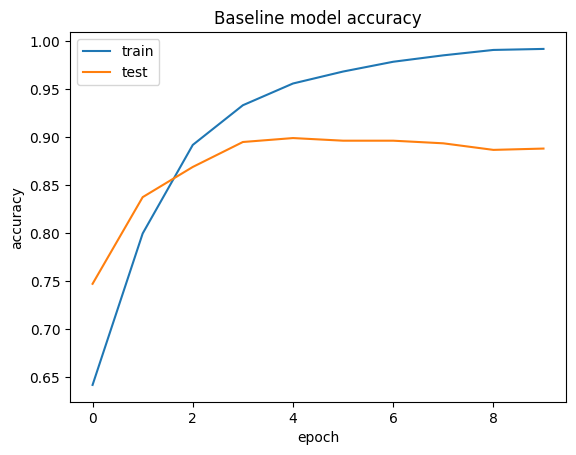

In [23]:
plt.plot(baseline_history.history['acc'])
plt.plot(baseline_history.history['val_acc'])
plt.title('Baseline model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

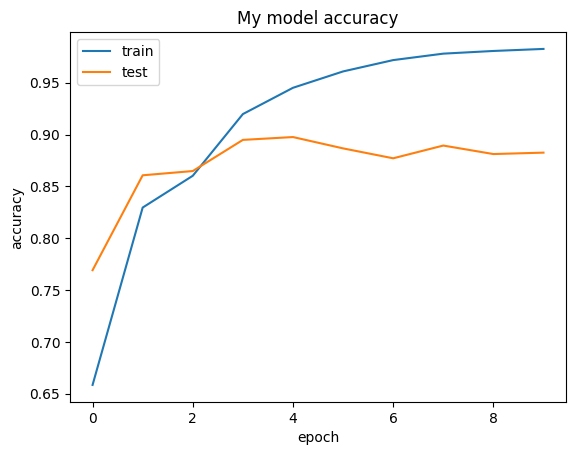

In [24]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('My model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

## Evaluate the Model Accuracy
Evaluate the models' accuracy by the following code cells.

In [25]:
# baseline model performance. The loss and accuracy are not deterministic, i.e., you may get different results when you run the code cell.
loss, accuracy = baseline.evaluate(X_test, y_test, verbose=1)
print("Loss Score:", loss)
print("Test Accuracy:", accuracy)

229/229 [==============================] - 2s 7ms/step - loss: 0.3011 - acc: 0.8929
Loss Score: 0.30105873942375183
Test Accuracy: 0.8928961753845215


In [26]:
# Your model performance
loss, accuracy = model.evaluate(X_test, y_test, verbose=1)
print("Loss Score:", loss)
print("Test Accuracy:", accuracy)

229/229 [==============================] - 15s 61ms/step - loss: 0.2843 - acc: 0.9003
Loss Score: 0.284265398979187
Test Accuracy: 0.9002732038497925


## **Submission to ZINC**
After completing the missing functions in this notebook, successfully running the code, and achieving the task score requirement, please COPY your functions to the template lab6_task.py (do not change the file name) given in the lab6 webpage, **DIRECTLY COMPRESS the 3 items** (lab6_task.py, X_test.npy, weights.hdf5) to a zip file instead of compressing a folder containing the 3 items. Submit ONLY the zip file to ZINC.

# Unmount Google Drive

In [27]:
drive.flush_and_unmount()